In [53]:
%matplotlib inline

import os
import sys
import time
import numpy as np
from matplotlib import pyplot as plt, ticker
import random
from pysar.utils.solvers import l1reg_lstsq
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

# specified time-series
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
tbase = np.array(ts_obj.tbase)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt


number of ifgrams: 475
number of triplets: 940
ifgram with unwrap error: 0.2
unwrap error jump in 2*pi*(-5, 5): 
number of ifgrams with unwrap error: 95
max perpendicular baseline: 214.31 m
max temporal      baseline: 120.0 days


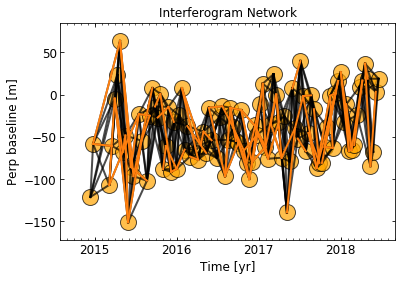

In [58]:
## Simulate interferograms with unwrapping errors

# temp/spatial baseline
#date_list = ts_obj.dateList[:4] + ts_obj.dateList[7:10]
#pbase = ts_obj.pbase[:4].tolist() + ts_obj.pbase[7:10].tolist()
date_list = ts_obj.dateList#[:50]
pbase = ts_obj.pbase#[:50].tolist()
dates = ptime.date_list2vector(date_list)[0]

# network setup
date12_list = pnet.select_pairs_sequential(date_list, num_connection=5, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of ifgrams: {}'.format(num_ifgram))
print('number of triplets: {}'.format(C.shape[0]))

# simulate ifgram without unwrap error
ifgram_sim = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid, L=3*9, num_sample=1, baseline_file='bl_list.txt', sensor_name=sensor_name, inc_angle=inc_angle)[0].flatten()
# add unwrap error
#idx_ifg_err = random.sample(list(range(len(ifgram_sim))), 5)
#ifgram_err = np.array(ifgram_sim, dtype=np.float32)
#ifgram_err[idx_ifg_err] += 2.*np.pi*2.
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram_sim, percentage=0.2, Nmax=5, print_msg=True)

# plot
fig, ax = plt.subplots()
pp.plot_network(ax, date12_list, date_list, pbase)
# plot interferometric pairs with error
for date12 in np.array(date12_list)[idx_ifg_err]:
    date1, date2 = date12.split('_')
    idx1 = date_list.index(date1)
    idx2 = date_list.index(date2)
    x = [dates[idx1], dates[idx2]]
    y = [pbase[idx1], pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
# axis format
pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
ax.set_xlabel('Time [yr]', fontsize=font_size)
ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
plt.show()

In [59]:
ifgram = np.array(ifgram_err)
num_tri, num_ifgram = C.shape
ifgram = ifgram.reshape(num_ifgram, -1)

# integer ambiguity of the closure phase
closure_pha = np.dot(C, ifgram)
closure_int = ((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi)).astype(int)

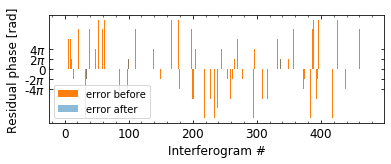

In [60]:
## Option 1 - LASSO using cvxopt - fast
from cvxopt import matrix, sparse
A = matrix(np.array(-C, dtype=float))
b = matrix(np.array(closure_int, dtype=float).reshape(num_tri, -1))
x = np.array(l1reg_lstsq(A, b, lambd=1e-2)).flatten()

U = np.round(x).reshape(num_ifgram, -1)
# corrected interferogram
ifgram_cor = ifgram + 2*np.pi*U
ifgram_cor = ifgram_cor.flatten()

# plot
fig, ax = plt.subplots(figsize=[6, 2])
x_list = np.arange(num_ifgram)
ax.bar(x_list, ifgram_err - ifgram_sim, color=pp.mplColors[1], label='error before')
ax.bar(x_list, ifgram_cor - ifgram_sim, color=pp.mplColors[0], label='error after', alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
#ax.set_xlim(0, ifgram.shape[0])
plt.legend()
plt.show()

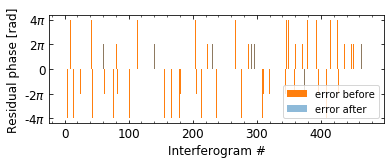

In [16]:
## Option 2 - LASSO using cvxopt - slow
import cvxpy as cp
x = cp.Variable(num_ifgram, integer=False)
lambd = cp.Parameter(nonneg=True)
lambd.value = 1e-2
A = np.array(-C)
b = closure_int.flatten()
obj = cp.Minimize(cp.sum_squares(cp.matmul(A, x) - b) + lambd * cp.norm1(x))
prob = cp.Problem(obj)
prob.solve()

U = np.round(x.value).reshape(num_ifgram, -1)

# corrected interferogram
ifgram_cor = ifgram_err + 2*np.pi*U
ifgram_cor = ifgram_cor.flatten()

# plot
fig, ax = plt.subplots(figsize=[6, 2])
x_list = np.arange(num_ifgram)
ax.bar(x_list, ifgram_err - ifgram_sim, color=pp.mplColors[1], label='error before')
ax.bar(x_list, ifgram_cor - ifgram_sim, color=pp.mplColors[0], label='error after', alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
#ax.set_xlim(0, ifgram.shape[0])
plt.legend()
plt.show()

In [61]:
## Find the proper LASSO coefficient - lambda - for the degree of shrinkage

import time
lambd_values = np.logspace(-4, 3, 50)
num_err_list = []
for v in lambd_values:
    start_time = time.time()
    x = np.array(l1reg_lstsq(A, b, lambd=v)).flatten()
    sys.stdout.write('\rlambda value: {:6.6f} \t time used: {:02.3f} secs.\n'.format(v, time.time()-start_time))
    sys.stdout.flush()
    unw_err = np.round((ifgram_err + 2*np.pi*np.round(x) - ifgram_sim) / (2.0 * np.pi))
    num_err = np.sum(unw_err != 0)
    num_err_list.append(num_err)
print('Done.')

lambda value: 0.000100 	 time used: 0.123 secs.
lambda value: 0.000139 	 time used: 0.123 secs.
lambda value: 0.000193 	 time used: 0.114 secs.
lambda value: 0.000268 	 time used: 0.107 secs.
lambda value: 0.000373 	 time used: 0.098 secs.
lambda value: 0.000518 	 time used: 0.098 secs.
lambda value: 0.000720 	 time used: 0.096 secs.
lambda value: 0.001000 	 time used: 0.096 secs.
lambda value: 0.001389 	 time used: 0.103 secs.
lambda value: 0.001931 	 time used: 0.106 secs.
lambda value: 0.002683 	 time used: 0.105 secs.
lambda value: 0.003728 	 time used: 0.105 secs.
lambda value: 0.005179 	 time used: 0.123 secs.
lambda value: 0.007197 	 time used: 0.125 secs.
lambda value: 0.010000 	 time used: 0.123 secs.
lambda value: 0.013895 	 time used: 0.124 secs.
lambda value: 0.019307 	 time used: 0.124 secs.
lambda value: 0.026827 	 time used: 0.118 secs.
lambda value: 0.037276 	 time used: 0.144 secs.
lambda value: 0.051795 	 time used: 0.116 secs.
lambda value: 0.071969 	 time used: 0.11

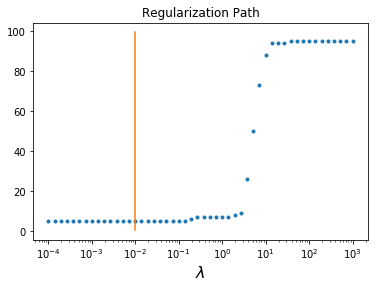

In [62]:
fig, ax = plt.subplots()
ax.plot(lambd_values, num_err_list, '.')
ax.plot([0.01, 0.01], ax.get_ylim())
ax.set_xlabel(r"$\lambda$", fontsize=16)
ax.set_xscale("log")
ax.set_title("Regularization Path")
plt.show()

Thus, choose lambd = 0.01 for the LASSO regression.